In [1]:
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def sigmoid(x, a, b, c):
    return a / (1 + np.exp(-(x - c) / b))


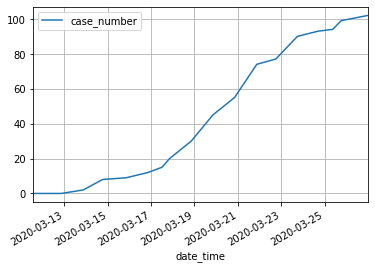

In [3]:
PLACEHOLDER_TIME = "23:59"

df = pd.read_csv("./jena_covid19_scraped.csv").replace({"time": {"None": PLACEHOLDER_TIME}})
df["date_time"] = pd.to_datetime(df["date"] + " " + df["time"])
df.plot(x="date_time", y="case_number")
plt.grid("on")

Let's convert time stamps to the number of days and normalize the variables

In [4]:
dt = df.date_time - df.date_time[0]
day = np.timedelta64(1, "D")
x = (dt / day).values
y = df.case_number.values.astype(float)

In [5]:
mu_x = x.mean()
sigma_x = x.std()
ymax = y.max()
xn = (x - mu_x) / sigma_x
yn = y / ymax

# Logistic

In [6]:
with pm.Model() as model:
    a = pm.Normal("a", mu=1, sd=1)
    b = pm.Normal("b", mu=1, sd=1)
    c = pm.Normal("c", mu=0, sd=1)
    eps = pm.HalfCauchy("eps", beta=1)
    mu = pm.Deterministic("y", a / (1 + pm.math.exp(-(xn - c) / b)))
    y_like = pm.Normal('y_like', mu=mu, sd=eps, observed=yn)

    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, c, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1617.45draws/s]


/home/renat/envs/bayesian/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/renat/envs/bayesian/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/renat/envs/bayesian/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/renat/envs/bayesian/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupp

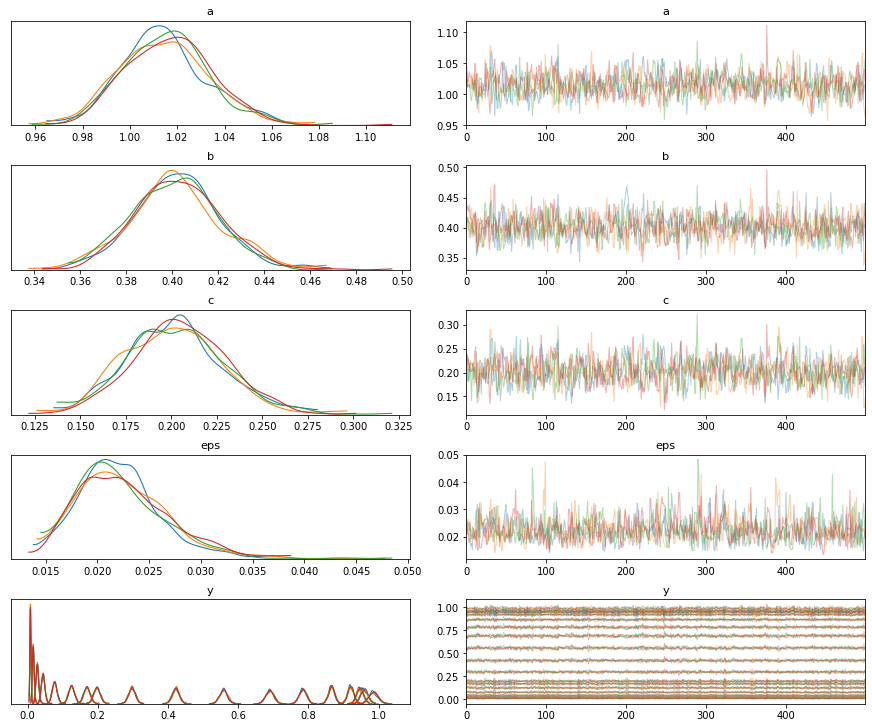

In [7]:
pm.traceplot(trace);

In [8]:
xnpp = np.linspace(-1.7, 3)
ynpp = sigmoid(xnpp[:, None], trace["a"][None, ::20], trace["b"][None, ::20], trace["c"][None, ::20])

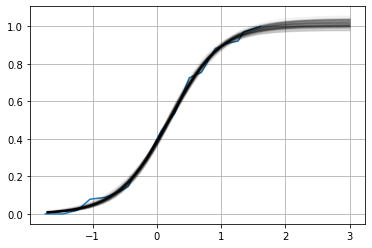

In [9]:
plt.plot(xn, yn);
plt.plot(xnpp, ynpp, c="k", alpha=.05);
plt.grid()

Back to the original units + some forecasting

In [10]:
xpp = np.linspace(0, 20)
ypp = sigmoid(xpp[:, None], 
              trace["a"][None, ::5] * ymax, 
              trace["b"][None, ::5] * sigma_x, 
              trace["c"][None, ::5] * sigma_x + mu_x)

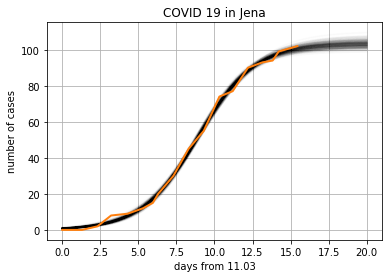

In [11]:
plt.plot(xpp, ypp, c="k", alpha=.01);
plt.plot(x, y, linewidth=2, c="C1");
plt.grid()
plt.title("COVID 19 in Jena")
plt.xlabel("days from 11.03")
plt.ylabel("number of cases")
plt.savefig("./sigmoid_bayes.png", dpi=150)